In [1]:
# %% [markdown]
# # Запуск проекта автодополнения текста из модулей с конфигурацией YAML

In [2]:
# %%
# --- Автоперезагрузка модулей при изменениях в коде ---
%load_ext autoreload
%autoreload 2

In [3]:
# %%
# --- Импорты ---
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from data_utils import process_file_and_save, tokens_to_indices, pad_sequences_torch, compute_rouge
from next_token_dataset import TextDataset
from lstm_model import LSTMModel
from eval_lstm import train_epoch, eval_epoch
from transformers import pipeline, AutoTokenizer
import re
import yaml

2025-09-14 17:22:10.714067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# %%
# --- Загрузка конфигурации из YAML ---
with open('/home/assistant/text-autocomplete/config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)
print("Текущая рабочая директория:", os.getcwd())

Текущая рабочая директория: /home/assistant/text-autocomplete/src


In [6]:
# %%
# --- Настройка устройства для вычислений (CPU/GPU) ---
device_name = config['environment']['device']
device = torch.device(device_name if torch.cuda.is_available() and device_name == 'cuda' else 'cpu')
print(f"Используем устройство: {device}")

Используем устройство: cuda


In [7]:
# %%
# --- Загрузка путей из конфига ---
paths = config['project']['paths']
input_file = paths['input_file']

In [8]:
# %%
# --- Обработка и подготовка данных ---
samples = process_file_and_save(input_file)
# Создание словаря токенов
all_tokens = [token for sample in samples for token in sample['X']] + [token for sample in samples for token in sample['Y']]
vocab = {token: idx + 1 for idx, token in enumerate(sorted(set(all_tokens)))}
vocab_size = len(vocab) + 1
# Индексация и паддинг
X_indices, Y_indices = tokens_to_indices(samples, vocab)
max_len = max(len(x) for x in X_indices)
X_pad = pad_sequences_torch(X_indices, max_len, torch)
Y_pad = pad_sequences_torch(Y_indices, max_len, torch)

Исходный набор данных сохранен в data/raw_dataset.csv
Токенизированный набор данных сохранен в data/dataset_processed.csv


In [9]:
# %%
# --- Разделение выборок на train, validation и test + сохранение CSV ---
split_cfg = config['dataset']['train_val_test_split']
X_train, X_temp, Y_train, Y_temp = train_test_split(X_pad, Y_pad, test_size=split_cfg['val_size'], random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=split_cfg['test_size_within_val'], random_state=42)
os.makedirs(paths['data_dir'], exist_ok=True)
def tensor_to_str_list(tensor):
    return [' '.join(map(str, seq.tolist())) for seq in tensor]
pd.DataFrame({'X': tensor_to_str_list(X_train), 'Y': tensor_to_str_list(Y_train)}).to_csv(paths['train_data'], index=False, encoding=config['data_processing']['encoding'])
print(f"Файл обучающей выборки сохранён: {paths['train_data']}")
pd.DataFrame({'X': tensor_to_str_list(X_val), 'Y': tensor_to_str_list(Y_val)}).to_csv(paths['val_data'], index=False, encoding=config['data_processing']['encoding'])
print(f"Файл валидационной выборки сохранён: {paths['val_data']}")
pd.DataFrame({'X': tensor_to_str_list(X_test), 'Y': tensor_to_str_list(Y_test)}).to_csv(paths['test_data'], index=False, encoding=config['data_processing']['encoding'])
print(f"Файл тестовой выборки сохранён: {paths['test_data']}")

Файл обучающей выборки сохранён: /home/assistant/text-autocomplete/data/train.csv
Файл валидационной выборки сохранён: /home/assistant/text-autocomplete/data/val.csv
Файл тестовой выборки сохранён: /home/assistant/text-autocomplete/data/test.csv


In [10]:
# %%
# --- Создание DataLoader для обучения и валидации ---
batch_size = config['dataset']['batch_size']
train_dataset = TextDataset(X_train, Y_train)
val_dataset = TextDataset(X_val, Y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)


In [11]:
# %%
# --- Инициализация модели, функции потерь и оптимизатора ---
lstm_cfg = config['model']['lstm']
embedding_dim = lstm_cfg['embedding_dim']
hidden_dim = lstm_cfg['hidden_dim']
padding_idx = lstm_cfg['padding_idx']
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, padding_idx=padding_idx).to(device)  # Убедитесь в передаче padding_idx

training_cfg = config['training']
criterion = torch.nn.CrossEntropyLoss(ignore_index=training_cfg['loss_function']['ignore_index'])
optimizer_cls = getattr(torch.optim, training_cfg['optimizer']['type'])
optimizer = optimizer_cls(model.parameters(), **training_cfg['optimizer']['params'])

In [14]:
# %%
# --- Обучение и валидация модели ---
epochs = training_cfg['epochs']
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = eval_epoch(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if training_cfg['logging']['print_epoch_results']:
        print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")


Epoch 1/10 - train_loss: 4.6503, val_loss: 4.8872
Epoch 2/10 - train_loss: 4.6426, val_loss: 4.8871
Epoch 3/10 - train_loss: 4.6359, val_loss: 4.8875
Epoch 4/10 - train_loss: 4.6297, val_loss: 4.8870
Epoch 5/10 - train_loss: 4.6243, val_loss: 4.8876
Epoch 6/10 - train_loss: 4.6194, val_loss: 4.8876
Epoch 7/10 - train_loss: 4.6146, val_loss: 4.8865
Epoch 8/10 - train_loss: 4.6104, val_loss: 4.8876
Epoch 9/10 - train_loss: 4.6065, val_loss: 4.8884
Epoch 10/10 - train_loss: 4.6031, val_loss: 4.8894


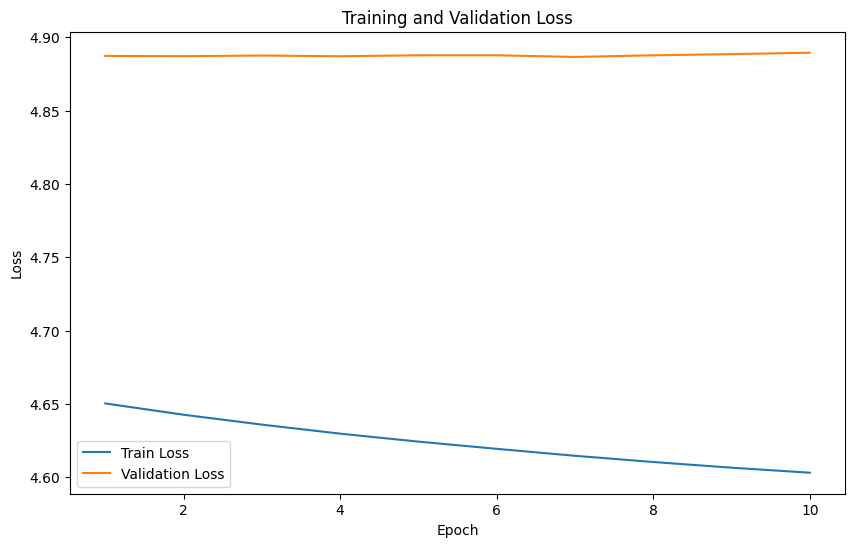

In [15]:
# %%
# --- Построение графика потерь ---
plot_cfg = config['output']['plots']
plt.figure(figsize=plot_cfg['figsize'])
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel(plot_cfg['xlabel'])
plt.ylabel(plot_cfg['ylabel'])
plt.title(plot_cfg['title'])
if plot_cfg['legend']:
    plt.legend()
plt.show()

In [16]:
# %%
# --- Сохранение обученной модели ---
os.makedirs(os.path.dirname(paths['model_weights']), exist_ok=True)
torch.save(model.state_dict(), paths['model_weights'])
print(f"Модель сохранена по пути {paths['model_weights']}")

Модель сохранена по пути /home/assistant/text-autocomplete/models/model_lstm_weights.pth


In [ ]:
# %%
# --- Пример генерации текста с LSTM-моделью ---

def generate_text_lstm(model, start_text, vocab, max_len=50, device='cpu'):
    model.eval()
    idx_to_token = {idx: token for token, idx in vocab.items()}
    idx_to_token[0] = '<PAD>'
    tokens = [vocab.get(token, 0) for token in start_text.split()]
    start_token = tokens[0] if tokens else 0
    generated_ids = model.forward(torch.tensor([[start_token]], device=device), mode='generate', max_len=max_len, start_token=start_token)
    generated_words = [idx_to_token.get(tok_id, '<UNK>') for tok_id in generated_ids]
    return ' '.join(generated_words)

start_seq = "Начало генерации текста"
generated_lstm_text = generate_text_lstm(model, start_seq, vocab, max_len=30, device=device)
print(f"\nПример генерации LSTM: \"{start_seq}\"")
print(generated_lstm_text)


Пример генерации LSTM: "Начало генерации текста"
<PAD> meadow ##ary to the first one i have to go to work tomorrow i have to go to work tomorrow and i have to go to work tomorrow and i


In [50]:
import torch
from torch.utils.data import DataLoader, Dataset
from rouge_score import rouge_scorer
import numpy as np

# Пример класса Dataset, разбивающего текст на input (3/4) и target (1/4)
class TextDataset(Dataset):
    def __init__(self, texts, vocab):
        self.texts = texts
        self.vocab = vocab
        self.idx_to_token = {idx: token for token, idx in vocab.items()}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx].split()
        split_idx = (len(tokens) * 3) // 4
        input_tokens = tokens[:split_idx]
        target_tokens = tokens[split_idx:]
        input_ids = [self.vocab.get(tok, 0) for tok in input_tokens]
        target_ids = [self.vocab.get(tok, 0) for tok in target_tokens]
        return torch.tensor(input_ids), torch.tensor(target_ids)

# Функция для подсчёта ROUGE
def compute_rouge(reference, prediction):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
    scores = scorer.score(reference, prediction)
    return scores['rouge1'].fmeasure, scores['rouge2'].fmeasure

# Функция оценки модели с использованием autocompletion
def evaluate_model_rouge(model, dataloader, tokenizer, vocab, device='cpu', max_generate_len=50):
    model.to(device)
    model.eval()

    idx_to_token = {idx: token for token, idx in vocab.items()}
    rouge1_scores = []
    rouge2_scores = []

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            for i in range(batch_inputs.size(0)):
                input_ids = batch_inputs[i].unsqueeze(0)  # [1, seq_len]
                target_ids = batch_targets[i]

                # Преобразуем input_ids в seed_text через словарь
                seed_text = ' '.join([idx_to_token.get(idx.item(), '<UNK>') for idx in input_ids[0]])

                # Вызываем generate с правильной сигнатурой
                generated_ids = model.generate(tokenizer, vocab, seed_text, max_length=max_generate_len)

                # Перекодируем индексы в текст
                generated_text = ' '.join([idx_to_token.get(tok, '<UNK>') for tok in generated_ids])
                target_text = ' '.join([idx_to_token.get(tok.item(), '<UNK>') for tok in target_ids])

                r1, r2 = compute_rouge(target_text, generated_text)
                
                rouge1_scores.append(r1)
                rouge2_scores.append(r2)

    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0.0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0.0

    return avg_rouge1, avg_rouge2

# подготовка данных и вызов функции

df = pd.read_csv('/home/assistant/text-autocomplete/data/raw_dataset.csv')
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['text'].tolist()

dataset = TextDataset(texts, vocab)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                                    torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
avg_rouge1, avg_rouge2 = evaluate_model_rouge(model, dataloader, tokenizer, vocab, device=device, max_generate_len=50)


print(f"Среднее ROUGE-1: {avg_rouge1:.4f}")
print(f"Среднее ROUGE-2: {avg_rouge2:.4f}")


Среднее ROUGE-1: 0.0402
Среднее ROUGE-2: 0.0282


In [51]:
# %%
# --- Оценка предобученной модели distilgpt2 с pipeline из transformers ---

from transformers import pipeline, AutoTokenizer
import re
import numpy as np
from sklearn.model_selection import train_test_split

generator_distilgpt2 = pipeline(
    "text-generation", 
    model=config['tokenizer']['distilgpt2_model_name'],
    tokenizer=config['tokenizer']['distilgpt2_model_name']
)

tokenizer_distilgpt2 = AutoTokenizer.from_pretrained(config['tokenizer']['distilgpt2_model_name'])


def split_text_for_completion(text):
    # Явно указываем truncation=True при токенизации
    tokens = tokenizer_distilgpt2.tokenize(text, max_length=16, truncation=True)
    cut_off = (len(tokens) * 3) // 4
    input_text = tokenizer_distilgpt2.convert_tokens_to_string(tokens[:cut_off])
    target_text = tokenizer_distilgpt2.convert_tokens_to_string(tokens[cut_off:])
    return input_text, target_text


def clean_text_for_distilgpt2(text):
    text = text.lower()
    text = re.sub(config['data_processing']['clean_text_regex']['urls'], '', text)
    text = re.sub(config['data_processing']['clean_text_regex']['mentions'], '', text)
    text = re.sub(r'[^\w\sа-яёa-z]', '', text, flags=re.UNICODE)
    text = re.sub(config['data_processing']['clean_text_regex']['whitespace'], ' ', text).strip()
    return text


texts = [clean_text_for_distilgpt2(t) for t in open(input_file, encoding=config['data_processing']['encoding']).readlines() if len(t.strip()) > 10]
_, val_texts = train_test_split(texts, test_size=split_cfg['val_size'], random_state=42)


rouge1_gpt2_scores, rouge2_gpt2_scores = [], []
print("Оцениваем модель distilgpt2...")
max_examples = config['evaluation']['validation_samples_limit']
print_limit = config['evaluation']['print_examples_limit']


for idx, text in enumerate(val_texts[:max_examples]):
    input_text, ref_text = split_text_for_completion(text)
    # Определяем максимальную длину генерируемых токенов (можно ограничить отдельно)
    max_new_tokens_gpt2 = 256 
    gpt2_out = generator_distilgpt2(
        input_text,
        max_new_tokens=max_new_tokens_gpt2,
        do_sample=config['model']['distilgpt2']['use_sampling'],
        top_k=config['model']['distilgpt2']['top_k'],
        num_return_sequences=config['model']['distilgpt2']['num_return_sequences'],
        truncation=True  # Явное указание усечения при генерации
    )
    gpt2_pred = gpt2_out[0]['generated_text'][len(input_text):].strip()
    r1_gpt2, r2_gpt2 = compute_rouge(ref_text, gpt2_pred)
    rouge1_gpt2_scores.append(r1_gpt2)
    rouge2_gpt2_scores.append(r2_gpt2)
    if idx < print_limit:
        print(f"\nПример #{idx+1}")
        print("Вход:", input_text)
        print("Эталон:", ref_text)
        print(f"distilgpt2 предсказание: {gpt2_pred}")
        print(f"ROUGE-1: {r1_gpt2:.3f}, ROUGE-2: {r2_gpt2:.3f}")


print(f"\nСреднее ROUGE-1 distilgpt2: {np.mean(rouge1_gpt2_scores):.3f}")
print(f"Среднее ROUGE-2 distilgpt2: {np.mean(rouge2_gpt2_scores):.3f}")


Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Оцениваем модель distilgpt2...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Пример #1
Вход: beautiful day for a tandem ribang blowout rear tire
Эталон:  a mile from home
distilgpt2 предсказание: , good look and a few good-looking camo/sport parts for the look.
ROUGE-1: 0.118, ROUGE-2: 0.000

Пример #2
Вход: i wish i could get them
Эталон:  but i cant
distilgpt2 предсказание: , and will give them a chance to make it or else i will get them.
ROUGE-1: 0.111, ROUGE-2: 0.000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Пример #3
Вход: very bummed my favorite venue of all time glad that it
Эталон:  was at 7 am
distilgpt2 предсказание: 's a place for me to hang out with my friends and family - and I'm very happy that this place is just where I can hang out with my friends and family for a while. I'm looking forward to seeing it again, and I'm sure it'll be great to see it continue. Thanks for stopping by!
ROUGE-1: 0.000, ROUGE-2: 0.000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Пример #4
Вход: indeed to the
Эталон:  whole discussion
distilgpt2 предсказание: point where the country was not in good shape, and of the future in which the world was not functioning.

It was a very big mistake for the people of the country that it was too difficult to see the future. Not because many of us were trying to understand the problems, but because it was difficult to understand the vision of our country.
We were aware of the problems, we had to get a better understanding of what is really happening and the problems. But we felt that we were having a very difficult time and that we were in good shape.
But we were also aware that there was a huge gap in the way the country was functioning. We had to figure out how to fix it.
Our country was struggling because we had to think about what might be the best way to solve the problem.
But we were also aware that the government was being dragged on.
We were aware that the government was having problems and that we were in great sh

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Пример #5
Вход: omg its almost 11 pm and im just now getting in
Эталон:  bed tomorrows
distilgpt2 предсказание: touch with me to talk about my friend, the new kid, the new lady, the new kid. I want her to know that I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I love her, I
ROUGE-1: 0.000, ROUGE-2: 0.000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Среднее ROUGE-1 distilgpt2: 0.018
Среднее ROUGE-2 distilgpt2: 0.001
